**Before running this notebook, please run script `src/ijcai15_setup.py` to setup data properly.**

In [1]:
%matplotlib inline

import os
import math
import random
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
nfeatures = 8 # number of features
EPS = 1e-9    # smooth, deal with 0 probability

In [3]:
data_dir = 'data/data-ijcai15'
fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')

In [4]:
visits = pd.read_csv(fvisit, sep=';')
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID
0,355803498,10063645@N00,1168492531,17,Structure,1303,1
1,355803564,10063645@N00,1168492549,17,Structure,1303,1
2,355803639,10063645@N00,1168492558,17,Structure,1303,1
3,1431486935,10091295@N02,1190421746,12,Cultural,1208,2
4,1432364530,10091295@N02,1190421792,12,Cultural,1208,2


In [5]:
coords = pd.read_csv(fcoord, sep=';')
coords.head()

,photoID,photoLon,photoLat
0,355803498,-3.187738,55.949806
1,355803564,-3.187736,55.949802
2,355803639,-3.187706,55.949764
3,1431486935,-3.206677,55.947060
4,1432364530,-3.206677,55.947060


In [6]:
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,355803498,10063645@N00,1168492531,17,Structure,1303,1,-3.187738,55.949806
1,355803564,10063645@N00,1168492549,17,Structure,1303,1,-3.187736,55.949802
2,355803639,10063645@N00,1168492558,17,Structure,1303,1,-3.187706,55.949764
3,1431486935,10091295@N02,1190421746,12,Cultural,1208,2,-3.206677,55.947060
4,1432364530,10091295@N02,1190421792,12,Cultural,1208,2,-3.206677,55.947060


In [7]:
pd.DataFrame([traj[['photoLon', 'photoLat']].min(), traj[['photoLon', 'photoLat']].max(), \
             traj[['photoLon', 'photoLat']].max() - traj[['photoLon', 'photoLat']].min()], \
             index = ['min', 'max', 'range'])

,photoLon,photoLat
min,-3.404581,55.918015
max,-3.159000,56.002472
range,0.245581,0.084457


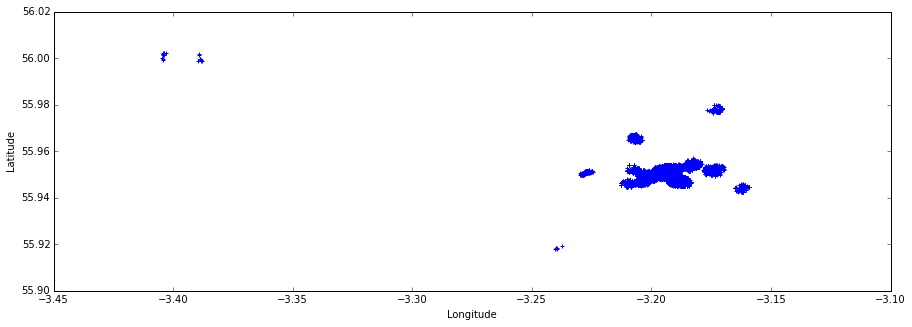

In [8]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

In [9]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame([num_photo, num_user, num_seq, num_photo/num_user, num_seq/num_user], \
             index = ['#photo', '#user', '#seq', '#photo/user', '#seq/user'], columns=['Edinburgh'])

,Edinburgh
#photo,33944.000000
#user,1454.000000
#seq,5028.000000
#photo/user,23.345254
#seq/user,3.458047


### Compute POI DataFrame

POI category and visiting frequency.

In [10]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)
#poi_catfreq

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [11]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)
#poi_coords

In [12]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Historical,4569,-3.199862,55.948847
2,Historical,699,-3.172468,55.952763
3,Museum,3140,-3.190347,55.946723
4,Structure,886,-3.175121,55.952234
5,Structure,12,-3.388720,55.999739
6,Structure,11,-3.404049,56.001282
7,Park,378,-3.161888,55.944121
8,Historical,1887,-3.193194,55.952539
9,Cultural,4452,-3.190637,55.949809


### Construct Travelling Sequences

In [13]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy()\
          .groupby(['userID', 'seqID', 'poiID']).agg([np.min, np.max])
#seq_all.head()

In [14]:
seq_all.columns = seq_all.columns.droplevel()
#seq_all.head()

In [15]:
seq_all.reset_index(inplace=True)
seq_all.head()

,userID,seqID,poiID,amin,amax
0,10063645@N00,1,17,1168492531,1168492558
1,10091295@N02,2,1,1190423814,1190423916
2,10091295@N02,2,12,1190421746,1190421901
3,10091295@N02,3,28,1190988000,1190988000
4,10091295@N02,4,10,1191029287,1191029561


In [16]:
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,poiDuration(sec)
0,10063645@N00,1,17,1168492531,1168492558,27
1,10091295@N02,2,1,1190423814,1190423916,102
2,10091295@N02,2,12,1190421746,1190421901,155
3,10091295@N02,3,28,1190988000,1190988000,0
4,10091295@N02,4,10,1191029287,1191029561,274


### Choose Travelling Sequences for experiment

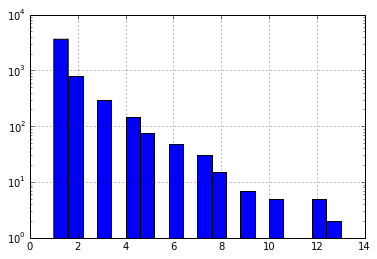

In [17]:
seq_len = seq_all[['userID', 'seqID', 'poiID']].copy()
seq_len = seq_len.groupby(['userID', 'seqID']).agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
#seq_len.head()
ax = seq_len['seqLen'].hist(bins=20)
ax.set_yscale('log')

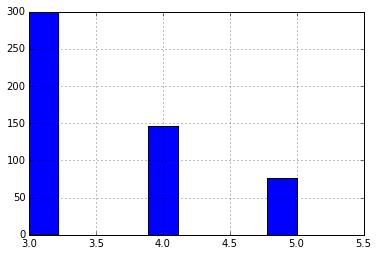

In [18]:
seq_345 = seq_len[seq_len['seqLen'].isin({3, 4, 5})]
seq_345['seqLen'].hist(bins=9)

### Split travelling sequences into training set and testing set using leave-one-out for each user  
*requires at least two travelling sequences for each user*

#### Sanity check: the total number of travelling sequences could be used in experiment.

In [19]:
seq_exp = seq_345[['userID', 'seqID']].copy()
seq_exp = seq_exp.groupby('userID').agg(np.size)
seq_exp.reset_index(inplace=True)
seq_exp.rename(columns={'seqID':'#seq'}, inplace=True)
seq_exp = seq_exp[seq_exp['#seq'] > 1]
print('total #seq for experiment:', seq_exp['#seq'].sum())
#seq_exp.head()

total #seq for experiment: 287


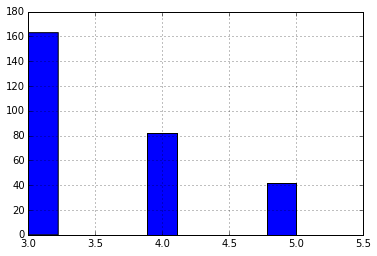

In [20]:
seqs = seq_345[seq_345['userID'].isin(seq_exp['userID'])]
seqs = seqs[seqs['seqLen'].isin({3, 4, 5})]
seqs['seqLen'].hist(bins=9)

In [21]:
train_set = []
test_set = []

In [22]:
user_seqs = seq_345[['userID', 'seqID']].groupby('userID')

In [23]:
for user, indices in user_seqs.groups.items():
    if len(indices) < 2: continue
    idx = random.choice(indices)
    test_set.append(seq_345.loc[idx, 'seqID'])
    train_set.extend([seq_345.loc[x, 'seqID'] for x in indices if x != idx])

#seq in trainset: 190
#seq in testset: 97


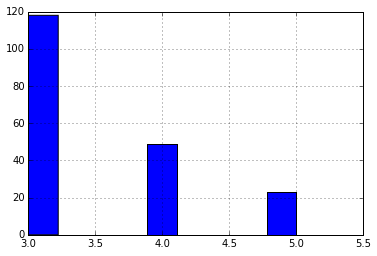

In [24]:
print('#seq in trainset:', len(train_set))
print('#seq in testset:', len(test_set))
seqs1 = seqs[seqs['seqID'].isin(train_set)]
seqs1['seqLen'].hist(bins=9)
#data = np.array(seqs1['seqLen'])
#hist, bins = np.histogram(data, bins=3)
#print(hist)

### Compute the transition matrix using travelling sequences in training set

In [25]:
poi_cats = traj['poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Cultural', 'Entertainment', 'Historical', 'Museum', 'Park', 'Structure']

In [26]:
ncats = len(poi_cats)
trans_mat = pd.DataFrame(data=np.zeros((ncats, ncats), dtype=np.float64), index=poi_cats, columns=poi_cats)
#trans_mat

In [27]:
#train_set = [4, 13, 32, 33, 34, 99, 101]
#seq_all[seq_all['seqID'] == train_set[0]]
for seqid in train_set:
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    for j in range(len(seqi.index)-1):
        idx1 = seqi.index[j]
        idx2 = seqi.index[j+1]
        poi1 = seqi.loc[idx1, 'poiID']
        poi2 = seqi.loc[idx2, 'poiID']
        cat1 = poi_all.loc[poi1, 'poiTheme']
        cat2 = poi_all.loc[poi2, 'poiTheme']
        trans_mat.loc[cat1, cat2] += 1
trans_mat

,Cultural,Entertainment,Historical,Museum,Park,Structure
Cultural,7,1,13,11,5,55
Entertainment,3,0,3,0,2,2
Historical,13,2,15,9,8,45
Museum,12,0,5,1,2,23
Park,6,0,10,3,0,17
Structure,36,7,47,31,22,59


In [28]:
for r in trans_mat.index:
    rowsum = trans_mat.ix[r].sum()
    for c in trans_mat.columns:
        trans_mat.loc[r, c] /= rowsum
trans_mat

,Cultural,Entertainment,Historical,Museum,Park,Structure
Cultural,0.076087,0.010870,0.141304,0.119565,0.054348,0.597826
Entertainment,0.300000,0.000000,0.300000,0.000000,0.200000,0.200000
Historical,0.141304,0.021739,0.163043,0.097826,0.086957,0.489130
Museum,0.279070,0.000000,0.116279,0.023256,0.046512,0.534884
Park,0.166667,0.000000,0.277778,0.083333,0.000000,0.472222
Structure,0.178218,0.034653,0.232673,0.153465,0.108911,0.292079


### Compute POI Popularity, Time/Frequency based User Interest using travelling sequences in training set

In [29]:
poi_avg_pop = seq_all[seq_all['seqID'].isin(train_set)]
poi_avg_pop = poi_avg_pop[['poiID', 'poiDuration(sec)']].copy()

In [30]:
poi_avg_pop = poi_avg_pop.groupby('poiID').agg([np.mean, np.size])
poi_avg_pop.columns = poi_avg_pop.columns.droplevel()
poi_avg_pop.reset_index(inplace=True)
poi_avg_pop.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
poi_avg_pop.set_index('poiID', inplace=True)
print('#poi:', poi_avg_pop.shape[0])
if poi_avg_pop.shape[0] < poi_all.shape[0]:
    extra_index = list(set(poi_all.index) - set(poi_avg_pop.index))
    extra_poi = pd.DataFrame(data=np.zeros((len(extra_index), 2), dtype=np.float64), \
                             index=extra_index, columns=['avgDuration(sec)', 'popularity'])
    poi_avg_pop = poi_avg_pop.append(extra_poi)
    print('#poi after extension:', poi_avg_pop.shape[0])
poi_avg_pop

#poi: 25
#poi after extension: 28


,avgDuration(sec),popularity
poiID,,
1,3555.868421,38
2,1854.352941,17
3,1851.272727,44
4,1415.000000,29
7,1134.428571,7
8,2022.705882,51
9,1607.714286,91
10,2557.692308,13
11,454.176471,17


In [31]:
user_interest = seq_all[seq_all['seqID'].isin(train_set)]
user_interest = user_interest[['userID', 'poiID', 'poiDuration(sec)']].copy()

In [32]:
user_interest['timeRatio'] = [poi_avg_pop.loc[x, 'avgDuration(sec)'] for x in user_interest['poiID']]
user_interest['timeRatio'] = user_interest['poiDuration(sec)'] / user_interest['timeRatio']
user_interest['poiTheme'] = [poi_all.loc[x, 'poiTheme'] for x in user_interest['poiID']]
user_interest.drop(['poiID', 'poiDuration(sec)'], axis=1, inplace=True)
user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.sum, np.size])
user_interest.columns = user_interest.columns.droplevel()
user_interest.rename(columns={'sum':'timeBased', 'size':'freqBased'}, inplace=True)
user_interest.reset_index(inplace=True)
user_interest.set_index(['userID', 'poiTheme'], inplace=True)
user_interest.head()

timeBased  freqBased
userID       poiTheme                        
10287726@N02 Historical   1.682166          1
             Structure    0.000000          2
10335112@N05 Historical   6.628254          3
             Structure    3.351103          2
10655856@N04 Cultural     0.000000          1

In [33]:
#user_interest.columns
#user_interest.index
#user_interest.loc['10287726@N02', 'Historical']['timeBased']
#user_interest.loc['10335112@N05', 'Park']['freqBased']
#('10335112@N05', 'Park') in user_interest.index # True

### Enumerate Trajectories

In [34]:
enum_seqs = dict()
train_seqs = dict()
poilist = poi_all.index.tolist()

In [35]:
for seqid in train_set:
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    train_seqs[seqid] = seqi['poiID'].tolist()
    p0 = seqi.loc[seqi.index[0], 'poiID']
    pN = seqi.loc[seqi.index[-1],'poiID']
    
    # enumerate sequences with length 3
    if seqi.shape[0] == 3:
        enum_seqs[seqid] = [[p0, p, pN] \
                            for p in poilist if p not in {p0, pN}]

    # enumerate sequences with length 4
    if seqi.shape[0] == 4:
        enum_seqs[seqid] = [[p0, p1, p2, pN] \
                            for p1 in poilist if p1 not in {p0, pN} \
                            for p2 in poilist if p2 not in {p0, p1, pN}]

    # enumerate sequences with length 5
    if seqi.shape[0] == 5:
        enum_seqs[seqid] = [[p0, p1, p2, p3, pN] \
                            for p1 in poilist if p1 not in {p0, pN} \
                            for p2 in poilist if p2 not in {p0, p1, pN} \
                            for p3 in poilist if p3 not in {p0, p1, p2, pN}]    

### Compute Features

In [36]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
                (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [37]:
poi_distmat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float64), \
                        index=poi_all.index, columns=poi_all.index)
poi_rdistmat = poi_distmat.copy()

In [38]:
for i in range(poi_all.index.shape[0]):
    for j in range(i+1, poi_all.index.shape[0]):
        r = poi_all.index[i]
        c = poi_all.index[j]
        dist = calc_dist(poi_all.loc[r, 'poiLon'], poi_all.loc[r, 'poiLat'], \
                         poi_all.loc[c, 'poiLon'], poi_all.loc[c, 'poiLat'])
        poi_distmat.loc[r, c] = dist
        poi_distmat.loc[c, r] = dist
        assert(dist > 0.)
        rdist = 1./dist
        poi_rdistmat.loc[r, c] = rdist
        poi_rdistmat.loc[c, r] = rdist

In [39]:
num_enum_seq = 0 # total number of enumerated sequences
score_indices = dict() # score vector index in the feature matrix

In [40]:
for seqid in train_set:
    num = len(enum_seqs[seqid])
    score_indices[seqid] = [x for x in range(num_enum_seq, num_enum_seq + num)]
    num_enum_seq += num

In [41]:
features = np.zeros((num_enum_seq, nfeatures), dtype=np.float64)

In [ ]:
features.shape

In [42]:
for seqid in train_set:
    user = seq_all[seq_all['seqID'] == seqid]['userID'].iloc[0]
    seqs = enum_seqs[seqid]
    indices = score_indices[seqid]
    assert(len(seqs) == len(indices))
    
    for j in range(len(seqs)):
        seq = seqs[j]
        idx = indices[j]
        assert(idx in range(num_enum_seq))
        
        # POI based features
        for poi in seq:
            cat = poi_all.loc[poi, 'poiTheme']
            if (user, cat) in user_interest.index:
                features[idx, 0] += user_interest.loc[user, cat]['timeBased'] # 1. time-based user interest
                features[idx, 1] += user_interest.loc[user, cat]['freqBased'] # 2. freq-based user interest
            if poi in poi_avg_pop.index:
                features[idx, 2] += poi_avg_pop.loc[poi, 'popularity']        # 3. POI popularity
    
        # POI-pair base features
        for k in range(len(seq)-1):
            poi1 = seq[k]
            poi2 = seq[k+1]
            #lon1 = poi_all.loc[poi1, 'poiLon']
            #lat1 = poi_all.loc[poi1, 'poiLat']
            #lon2 = poi_all.loc[poi2, 'poiLon']
            #lat2 = poi_all.loc[poi2, 'poiLat']
            #dist = calc_dist(lon1, lat1, lon2, lat2)
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']          
            
            features[idx, 3] += -1 * poi_distmat.loc[poi1, poi2]              # 4. travel distance        
   
            # features 5 to 8:
            # trajectory log(probability) based on the transition matrix between different POI categories 
            # and the following rules for choosing a specific POI within certain category:
            #  - The Nearest Neighbor of the current POI
            #  - The most Popular POI
            #  - A random POI choosing with probability proportional to the reciprocal of its distance to current POI
            #  - A random POI choosing with probability proportional to its popularity
            
            transprob = math.log10(trans_mat.loc[cat1, cat2] + EPS) # log of transition probability
            for l in range(4, 8):
                features[idx, l] += transprob
            
            poi_cat2 = poi_all[poi_all['poiTheme'] == cat2].copy()
            if cat1 == cat2: 
                poi_cat2.drop(poi1, axis=0, inplace=True) # drop row
            
            #distvec = pd.DataFrame(data=[1./calc_dist(lon1, lat1, poi_cat2.loc[x,'poiLon'], poi_cat2.loc[x,'poiLat']) \
            #                             for x in poi_cat2.index], index=poi_cat2.index)
            distvec = pd.DataFrame(data=[poi_rdistmat.loc[poi1, x] for x in poi_cat2.index], index=poi_cat2.index)
            if distvec.idxmax().iloc[0] == poi2:
                features[idx, 4] += math.log10(1. + EPS) # poi2 is the nearest neighbor of poi1
            else:
                features[idx, 4] += math.log10(0. + EPS) # poi2 is not the nearest neighbor of poi1
                
            popvec = pd.DataFrame(data=[poi_avg_pop.loc[x,'popularity'] for x in poi_cat2.index], index=poi_cat2.index)
            if popvec.idxmax().iloc[0] == poi2:
                features[idx, 5] += math.log10(1. + EPS) # poi2 is the most popular one within cat2
            else:
                features[idx, 5] += math.log10(0. + EPS) # poi2 is not the most popular one within cat2
             
            features[idx, 6] += math.log10(EPS + distvec.loc[poi2].iloc[0] / distvec.sum().iloc[0])
            features[idx, 7] += math.log10(EPS +  popvec.loc[poi2].iloc[0] /  popvec.sum().iloc[0])
            
        # normalise score, range [-1, 1]
        features[idx] /= abs(features[idx]).max()

### Experiment with Single Feature

In [43]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    return 2. * precision * recall / (precision + recall)

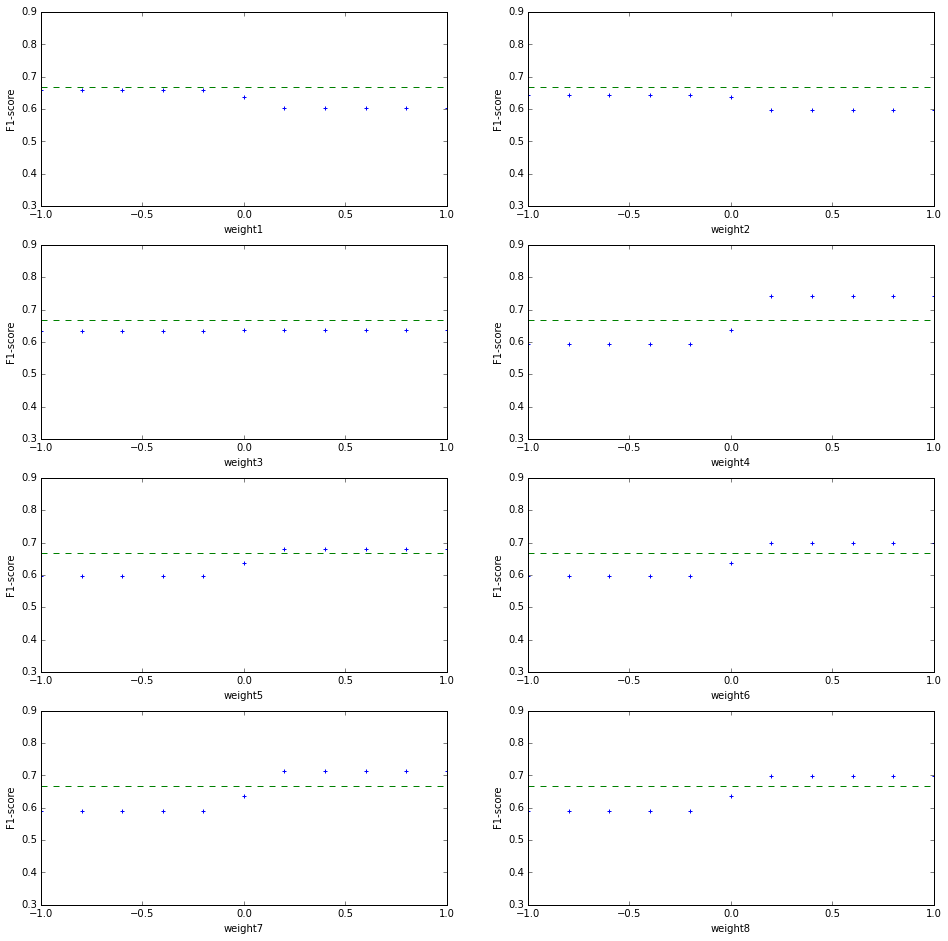

In [54]:
#values = [-0.5, 0, 0.5]
values = np.linspace(-1, 1, 11)
plt.figure(figsize=[16, 16])
for j in range(nfeatures):
    all_F1scores = []
    for k in range(len(values)):
        weights = np.zeros(nfeatures, dtype=np.float64)
        weights[j] = values[k]
        all_scores = features.dot(weights)
        F1scores = []
        for seqid in train_set:
            scores = np.array([all_scores[x] for x in score_indices[seqid]])
            bestseq = enum_seqs[seqid][scores.argmax()]
            F1scores.append(calc_F1score(train_seqs[seqid], bestseq))
        all_F1scores.append(F1scores)
    plt.subplot(4, 2, j+1)
    plt.xlim([-1, 1])
    plt.ylim([0.3, 0.9])
    plt.xlabel('weight' + str(j+1))
    plt.ylabel('F1-score')
    #plt.boxplot(all_F1scores, labels=values) #OK
    plt.scatter(values, [np.mean(x) for x in all_F1scores], marker='+')
    plt.plot([-1, 1], [0.667, 0.667], color='g', linestyle='--')